<a href="https://colab.research.google.com/github/cryssoga/DSWP/blob/master/Li%C3%A7%C3%A3o/NB15_00_CreditCard_RandomForest_CHURN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url_train = 'https://raw.githubusercontent.com/cryssoga/DSWP/master/Li%C3%A7%C3%A3o/train.csv'
url_test = 'https://raw.githubusercontent.com/cryssoga/DSWP/master/Li%C3%A7%C3%A3o/test.csv'
url_sample_submission = 'https://raw.githubusercontent.com/cryssoga/DSWP/master/Li%C3%A7%C3%A3o/sample_submission.csv'

# Lendo/carregando os dataframes:

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_sample_submission = pd.read_csv(url_sample_submission)

# 'TotalCharges' de object para numeric, mas antes tratando os campos ' ':

df_train[df_train['TotalCharges']==' ']
df_train['TotalCharges'] = df_train['TotalCharges'].replace(' ', '0')
df_train['TotalCharges'] = pd.to_numeric(df_train['TotalCharges'])

df_test[df_test['TotalCharges']==' ']
df_test['TotalCharges'] = df_test['TotalCharges'].replace(' ', '0')
df_test['TotalCharges'] = pd.to_numeric(df_test['TotalCharges'])

# Tratando os missing values nas variáveis 'PaymentMethod' (mais frequente), 'Dependents' (mais frequente) e 'tenure' (mediana)

df_train['PaymentMethod'].fillna('Eletronic check', inplace=True)
df_train['Dependents'].fillna('No',inplace = True)
df_train['tenure'].fillna(df_train['tenure'].median(), inplace=True)

df_test['PaymentMethod'].fillna('Eletronic check',inplace = True)
df_test['Dependents'].fillna('No', inplace=True)
df_test['tenure'].fillna(df_test['tenure'].median(),inplace = True)

# Dividindo df_train em df_X_train e df_y_train:
df_X_train = df_train.drop('Churn',axis=1)
df_X_train.head()
df_y_train = df_train['Churn']


In [108]:
X_treinamento = df_X_train
y_treinamento = df_y_train
X_teste = df_test
y_teste = df_sample_submission['Churn']

In [ ]:
y_teste

In [109]:
# Definindo variáveis globais:
i_CV = 10     # número de Cross-Validations (CV)
i_Seed = 20111974

from sklearn.model_selection import cross_val_score     # para CV (Cross-Validation)
from sklearn.model_selection import GridSearchCV        # para GridSearchCV (otimizar os parâmetros dos modelos preditivos)
from time import time                                   # requerida na função gridsearchcv
from sklearn.ensemble import RandomForestClassifier     # para o RandomForestClassifier
from sklearn.metrics import confusion_matrix            # para plotar a confusion matrix
import seaborn as sns

In [110]:
# Função para Cross-Validation:

def funcao_cross_val_score(modelo, X_treinamento, y_treinamento, CV):
    
    #versão com cross_val_score:
    a_scores_CV = cross_val_score(modelo, X_treinamento, y_treinamento, cv = CV)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    return a_scores_CV  # é um array com os scores a cada iteração do CV


In [111]:
# Função para Confusion Matrix:

def mostra_confusion_matrix(cf, 
                            group_names = None, 
                            categories = 'auto', 
                            count = True, 
                            percent = True, 
                            cbar = True, 
                            xyticks = False, 
                            xyplotlabels = True, 
                            sum_stats = True, 
                            figsize = (8, 8), 
                            cmap = 'Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [112]:
# função para GridSearchCV:

def GridSearchOptimizer(modelo, ml_Opt, d_Parametros, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas):
    ml_GridSearchCV = GridSearchCV(modelo, d_Parametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_treinamento, y_treinamento)
    tempo_elapsed = time()-start
    #print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Parâmetros que otimizam a classificação:
    print(f'\nParametros otimizados: {ml_GridSearchCV.best_params_}')
    
    if ml_Opt == 'ml_DT2':
        print(f'\nDecisionTreeClassifier *********************************************************************************************************')
        ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_RF2':
        print(f'\nRandomForestClassifier *********************************************************************************************************')
        ml_Opt = RandomForestClassifier(bootstrap= ml_GridSearchCV.best_params_['bootstrap'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_features= ml_GridSearchCV.best_params_['max_features'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_split'],
                                        n_estimators= ml_GridSearchCV.best_params_['n_estimators'],
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_AB2':
        print(f'\nAdaBoostClassifier *********************************************************************************************************')
        ml_Opt = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator=RandomForestClassifier(bootstrap = False, 
                                                                          max_depth = 10, 
                                                                          max_features = 'auto', 
                                                                          min_samples_leaf = 1, 
                                                                          min_samples_split = 2, 
                                                                          n_estimators = 400), 
                                    learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                    n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                    random_state = i_Seed)
        
    elif ml_Opt == 'ml_GB2':
        print(f'\nGradientBoostingClassifier *********************************************************************************************************')
        ml_Opt = GradientBoostingClassifier(learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                            n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                            max_depth = ml_GridSearchCV.best_params_['max_depth'], 
                                            min_samples_split = ml_GridSearchCV.best_params_['min_samples_split'], 
                                            min_samples_leaf = ml_GridSearchCV.best_params_['min_samples_leaf'], 
                                            max_features = ml_GridSearchCV.best_params_['max_features'])
        
    elif ml_Opt == 'ml_XGB2':
        print(f'\nXGBoostingClassifier *********************************************************************************************************')
        ml_Opt = XGBoostingClassifier(learning_rate= ml_GridSearchCV.best_params_['learning_rate'], 
                                      max_depth= ml_GridSearchCV.best_params_['max_depth'], 
                                      colsample_bytree= ml_GridSearchCV.best_params_['colsample_bytree'], 
                                      subsample= ml_GridSearchCV.best_params_['subsample'], 
                                      gamma= ml_GridSearchCV.best_params_['gamma'], 
                                      min_child_weight= ml_GridSearchCV.best_params_['min_child_weight'])
        
    # Treina novamente usando os parametros otimizados...
    ml_Opt.fit(X_treinamento, y_treinamento)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = funcao_cross_val_score(ml_Opt, X_treinamento, y_treinamento, i_CV)

    # Faz predições com os parametros otimizados...
    y_pred = ml_Opt.predict(X_teste)
  
    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(l_colunas, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_teste, y_pred)
    cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
    cf_categories = ['Zero', 'One']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_


RANDOM FORESTER

In [113]:
X_treinamento.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Eletronic check,45.05,2560.10
1,6731,Male,0,Yes,Yes,29.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80


In [114]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
    # 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    # 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    # 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    # 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
X_treinamento['gender_le'] = le.fit_transform(X_treinamento['gender'])
X_treinamento['SeniorCitizen_le'] = le.fit_transform(X_treinamento['SeniorCitizen'])
X_treinamento['Partner_le'] = le.fit_transform(X_treinamento['Partner'])
X_treinamento['Dependents_le'] = le.fit_transform(X_treinamento['Dependents'])
X_treinamento['PhoneService_le'] = le.fit_transform(X_treinamento['PhoneService'])
X_treinamento['MultipleLines_le'] = le.fit_transform(X_treinamento['MultipleLines'])
X_treinamento['InternetService_le'] = le.fit_transform(X_treinamento['InternetService'])
X_treinamento['OnlineSecurity_le'] = le.fit_transform(X_treinamento['OnlineSecurity'])
X_treinamento['OnlineBackup_le'] = le.fit_transform(X_treinamento['OnlineBackup'])
X_treinamento['DeviceProtection_le'] = le.fit_transform(X_treinamento['DeviceProtection'])
X_treinamento['TechSupport_le'] = le.fit_transform(X_treinamento['TechSupport'])
X_treinamento['StreamingTV_le'] = le.fit_transform(X_treinamento['StreamingTV'])
X_treinamento['StreamingMovies_le'] = le.fit_transform(X_treinamento['StreamingMovies'])
X_treinamento['Contract_le'] = le.fit_transform(X_treinamento['Contract'])
X_treinamento['PaperlessBilling_le'] = le.fit_transform(X_treinamento['PaperlessBilling'])
X_treinamento['PaymentMethod_le'] = le.fit_transform(X_treinamento['PaymentMethod'])

In [115]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
    # 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    # 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    # 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    # 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
X_teste['gender_le'] = le.fit_transform(X_teste['gender'])
X_teste['SeniorCitizen_le'] = le.fit_transform(X_teste['SeniorCitizen'])
X_teste['Partner_le'] = le.fit_transform(X_teste['Partner'])
X_teste['Dependents_le'] = le.fit_transform(X_teste['Dependents'])
X_teste['PhoneService_le'] = le.fit_transform(X_teste['PhoneService'])
X_teste['MultipleLines_le'] = le.fit_transform(X_teste['MultipleLines'])
X_teste['InternetService_le'] = le.fit_transform(X_teste['InternetService'])
X_teste['OnlineSecurity_le'] = le.fit_transform(X_teste['OnlineSecurity'])
X_teste['OnlineBackup_le'] = le.fit_transform(X_teste['OnlineBackup'])
X_teste['DeviceProtection_le'] = le.fit_transform(X_teste['DeviceProtection'])
X_teste['TechSupport_le'] = le.fit_transform(X_teste['TechSupport'])
X_teste['StreamingTV_le'] = le.fit_transform(X_teste['StreamingTV'])
X_teste['StreamingMovies_le'] = le.fit_transform(X_teste['StreamingMovies'])
X_teste['Contract_le'] = le.fit_transform(X_teste['Contract'])
X_teste['PaperlessBilling_le'] = le.fit_transform(X_teste['PaperlessBilling'])
X_teste['PaymentMethod_le'] = le.fit_transform(X_teste['PaymentMethod'])

In [ ]:
X_teste.columns

In [116]:
X_treinamento = X_treinamento.drop(['id','gender', 'SeniorCitizen', 'Partner', 'Dependents',
                                 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],axis=1)

In [117]:
X_teste = X_teste.drop(['id','gender', 'SeniorCitizen', 'Partner', 'Dependents',
                                 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],axis=1)

In [119]:
# RandomForestClassifier

# Instancia...
ml_RF= RandomForestClassifier(n_estimators=100, min_samples_split= 2, max_features="auto", random_state = i_Seed)

# Treina...
ml_RF.fit(X_treinamento, y_treinamento)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20111974,
                       verbose=0, warm_start=False)

In [120]:
ml_RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20111974,
                       verbose=0, warm_start=False)

In [121]:
# Chama a função do Cross-Validation:

a_scores_CV = funcao_cross_val_score(ml_RF, X_treinamento, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 80.17
std médio das Acurácias calculadas pelo CV: 1.71


In [122]:
print(f'Acurácias: {a_scores_CV}')

Acurácias: [0.82092199 0.79255319 0.78014184 0.77659574 0.79040853 0.82060391
 0.8312611  0.79751332 0.80284192 0.80461812]


In [123]:
# Faz predições...
y_pred = ml_RF.predict(X_teste)

In [124]:
y_pred.shape

(1409,)

In [125]:
y_teste.shape

(1409,)

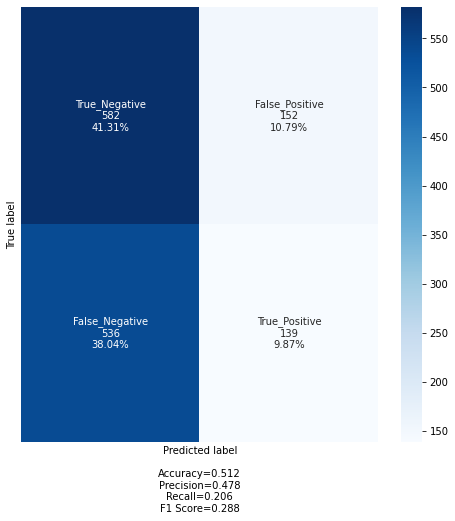

In [126]:
# Confusion Matrix
# chama a função confusion matrix:

cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative','False_Positive','False_Negative','True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [127]:
# Dicionário de parâmetros para o parameter tunning.
d_hiperparametros_RF= {'bootstrap': [True, False],
                  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [129]:
l_colunas = X_treinamento.columns
l_colunas

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_le',
       'SeniorCitizen_le', 'Partner_le', 'Dependents_le', 'PhoneService_le',
       'MultipleLines_le', 'InternetService_le', 'OnlineSecurity_le',
       'OnlineBackup_le', 'DeviceProtection_le', 'TechSupport_le',
       'StreamingTV_le', 'StreamingMovies_le', 'Contract_le',
       'PaperlessBilling_le', 'PaymentMethod_le'],
      dtype='object')

In [ ]:
# Invoca a função do GridSearch

ml_RF2, best_params = GridSearchOptimizer(ml_RF, 'ml_RF2', d_hiperparametros_RF, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

Fitting 10 folds for each of 3960 candidates, totalling 39600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.1s


In [ ]:
Guardar resultado

# Invoca a função do GridSearch

ml_RF2, best_params = GridSearchOptimizer(ml_RF, 'ml_RF2', d_hiperparametros_RF, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)


In [ ]:
NÃO EXECUTAR => Resultado:

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Parametros otimizados: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

RandomForestClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 80.74
std médio das Acurácias calculadas pelo CV: 1.22

********* IMPORTÂNCIA DAS COLUNAS ***********
                 coluna  importancia
3          TotalCharges     0.141395
1                tenure     0.140422
17          Contract_le     0.135134
2        MonthlyCharges     0.130394
0                    id     0.085080
11    OnlineSecurity_le     0.066907
14       TechSupport_le     0.055226
10   InternetService_le     0.043498
19     PaymentMethod_le     0.032531
12      OnlineBackup_le     0.028818
13  DeviceProtection_le     0.022682
18  PaperlessBilling_le     0.019800
4             gender_le     0.016114
9      MultipleLines_le     0.014936
15       StreamingTV_le     0.014094
16   StreamingMovies_le     0.013323
6            Partner_le     0.013253
5      SeniorCitizen_le     0.013109
7         Dependents_le     0.009333
8       PhoneService_le     0.003954

********* CONFUSION MATRIX - PARAMETER TUNNING ***********


In [ ]:
# RandomForestClassifier

# Instancia...
ml_RF= RandomForestClassifier(n_estimators=200, min_samples_split= 2, max_features="auto")

# Treina...
ml_RF.fit(X_treinamento, y_treinamento)

a_scores_CV = funcao_cross_val_score(ml_RF, X_treinamento, y_treinamento, i_CV)

# Faz predições...
y_pred = ml_RF.predict(X_teste)

# Dicionário de parâmetros para o parameter tunning.
d_hiperparametros_RF= {'bootstrap': [True, False],
                  'max_depth': [10,None],#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': [200]}#[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Confusion Matrix
# chama a função confusion matrix:

cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative','False_Positive','False_Negative','True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [ ]:
# Dicionário de parâmetros para o parameter tunning.
d_hiperparametros_RF= {'bootstrap': [True],
                  'max_depth': [None],#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'max_features': ['auto'],
                  'min_samples_leaf': [4],
                  'min_samples_split': [2]],
                  'n_estimators': [200]}#[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Visualizar os resultados:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

np.set_printoptions(suppress=True)

dot_data = StringIO()
export_graphviz(ml_RF2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = l_colunas, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())